This notebook will do the forecast for 
1. An ice-free condition on the northern hemisphere
2. Next year prediction for 3 regions : Sea of Okhotsk, Central Artic, Hudson Bay


In [2]:
#!pip install requests
#!pip install sklearn
#!pip install statsmodels
#!pip install pmdarima

In [3]:
# Importing required libraries
import requests
import pandas as pd
import csv
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor':'white'})

In [4]:
df = pd.read_csv('../Northern.csv',sep=",")
df.head()

,year_x,month_x,day_x,extent,missing,Source Data,datetime,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,...,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet,date,day_y,month_y,year_y,timestamp,dayofyear,hour
0,1978,10,26,10.231,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...,1978-10-26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1978,10,28,10.420,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...,1978-10-28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1978,10,30,10.557,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...,1978-10-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1978,11,1,10.670,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...,1978-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1978,11,3,10.777,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...,1978-11-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14186 entries, 0 to 14185
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   year_x                           14186 non-null  int64         
 1   month_x                          14186 non-null  int64         
 2   day_x                            14186 non-null  int64         
 3   extent                           14186 non-null  float64       
 4   missing                          14186 non-null  float64       
 5    Source Data                     14186 non-null  object        
 6   datetime                         14186 non-null  datetime64[ns]
 7   Northern_Hemisphere              5863 non-null   float64       
 8   Beaufort_Sea                     5863 non-null   float64       
 9    Chukchi_Sea                     5863 non-null   float64       
 10  East_Siberian_Sea                5863 non-null   float64  

In [6]:

import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='muted')
sns_c = sns.color_palette(palette='muted')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Set global plot parameters 
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [7]:
#import of the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ftplib import FTP
import os
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

[Text(0.5, 1.0, 'Sea ice extent on the Northern hemisphere')]

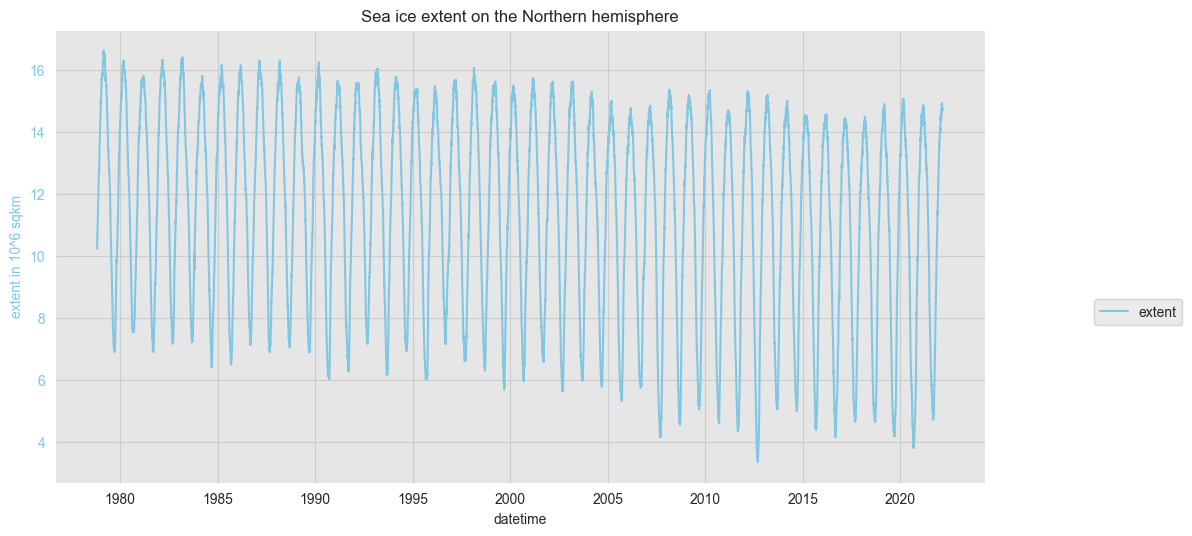

In [8]:
fig, ax1 = plt.subplots()
sns.lineplot(x='datetime', y='extent', data=df, color=sns_c[9], label='extent', ax=ax1)
ax1.legend(bbox_to_anchor=(1.22, 0.42))
ax1.tick_params(axis='y', labelcolor=sns_c[9])
ax1.set_ylabel('extent in 10^6 sqkm', fontdict={'color': sns_c[9]})
ax1.set(title='Sea ice extent on the Northern hemisphere')


In [9]:
#for the forecast we only need the timestamp and the extend value
df = df[['datetime', 'extent']]
print(df)

        datetime  extent
0     1978-10-26  10.231
1     1978-10-28  10.420
2     1978-10-30  10.557
3     1978-11-01  10.670
4     1978-11-03  10.777
...          ...     ...
14181 2022-03-03  14.703
14182 2022-03-04  14.748
14183 2022-03-05  14.762
14184 2022-03-06  14.756
14185 2022-03-07  14.769

[14186 rows x 2 columns]


First day of the dataset

In [10]:
df[df.extent.notna()].datetime.min()

Timestamp('1978-10-26 00:00:00')

Last day of dataset

In [11]:
df[df.extent.notna()].datetime.max()

Timestamp('2022-03-07 00:00:00')

Detect missing values:

In [12]:
df.shape[0]

14186

In [13]:
df[df.extent.notna()].shape[0]

14186

In [14]:
df["ds"] = df.datetime
df["y"] = df.extent

In [15]:
df

,datetime,extent,ds,y
0,1978-10-26,10.231,1978-10-26,10.231
1,1978-10-28,10.420,1978-10-28,10.420
2,1978-10-30,10.557,1978-10-30,10.557
3,1978-11-01,10.670,1978-11-01,10.670
4,1978-11-03,10.777,1978-11-03,10.777
...,...,...,...,...
14181,2022-03-03,14.703,2022-03-03,14.703
14182,2022-03-04,14.748,2022-03-04,14.748
14183,2022-03-05,14.762,2022-03-05,14.762
14184,2022-03-06,14.756,2022-03-06,14.756


In [16]:
df=df.drop(['datetime', 'extent'], axis=1)

Split data in train/test part, Train data till 31.12.2016, Test data from 1.1.2017.
Train the prophet on train data and predict for the Test data period.
Compare the forecast with Test data observations. Choose the RMSE as a metric

In [17]:
# Split data into train and test set
df_data = df['ds']
train_test_split_ratio = int(len(df_data)*0.8668)
train_data, test_data = df[:train_test_split_ratio], df[train_test_split_ratio:]

In [18]:
train_data

,ds,y
0,1978-10-26,10.231
1,1978-10-28,10.420
2,1978-10-30,10.557
3,1978-11-01,10.670
4,1978-11-03,10.777
...,...,...
12291,2016-12-27,12.291
12292,2016-12-28,12.484
12293,2016-12-29,12.525
12294,2016-12-30,12.617


In [19]:
m = Prophet(seasonality_mode='additive')
m.fit(train_data[["ds", "y"]])
future = m.make_future_dataframe(periods=len(test_data))
forecast = m.predict(future)
forecast["errors"] = forecast.yhat - df.y

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -263.421
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       39746.8    0.00712605       2265.93           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       39822.7      0.003977       1205.93      0.4709           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       39937.2     0.0098753       1785.27           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       39987.4    0.00471133       648.618           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       40016.5    0.00896111       430.944           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

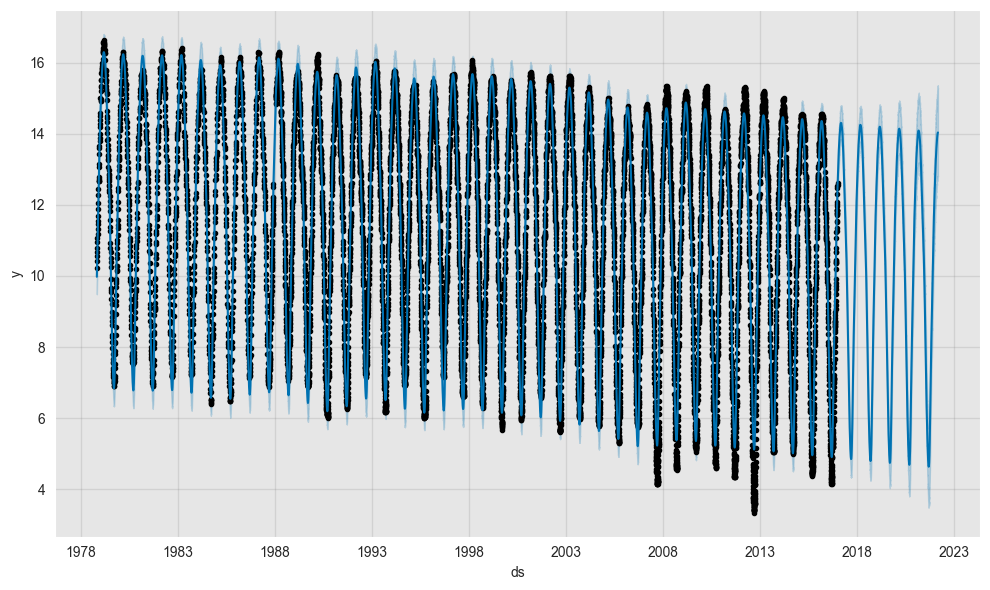

In [20]:
fig1 = m.plot(forecast)

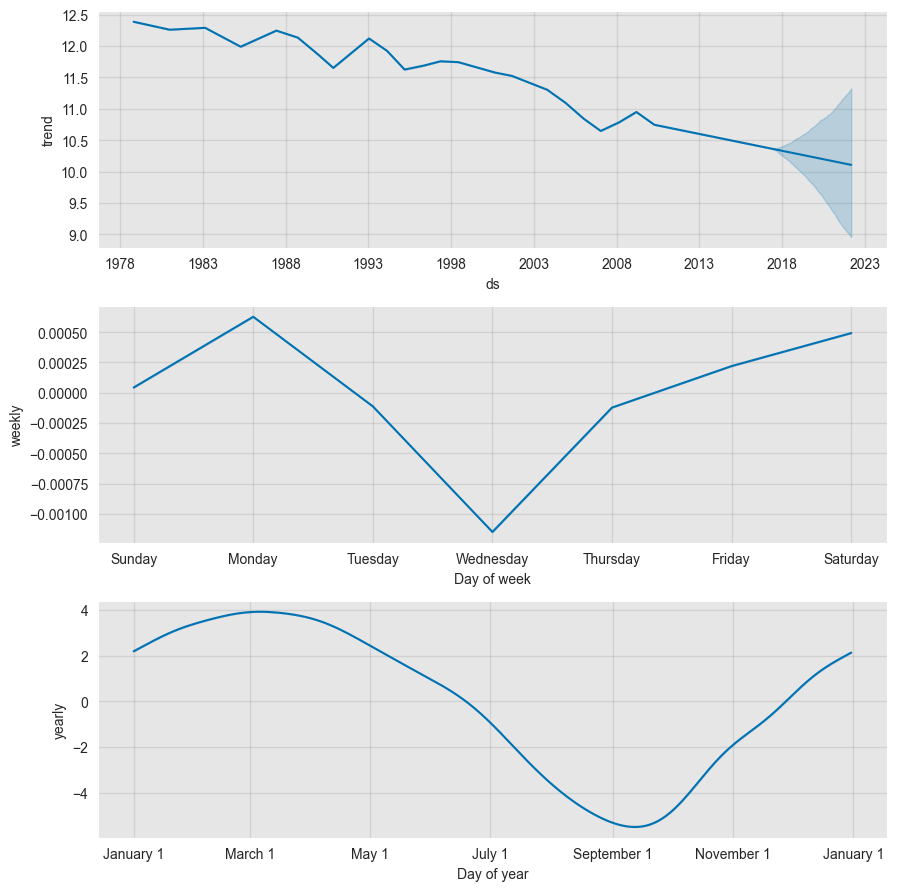

In [21]:
fig2 = m.plot_components(forecast)

In [22]:
predict_train, predict_test = forecast[:train_test_split_ratio], forecast[train_test_split_ratio:]

In [23]:
predict_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,errors
12296,2017-01-01,10.385064,12.092702,13.054114,10.385064,10.385064,2.197532,2.197532,2.197532,0.000043,0.000043,0.000043,2.197488,2.197488,2.197488,0.0,0.0,0.0,12.582595,-0.060405
12297,2017-01-02,10.384916,12.161644,13.133981,10.384916,10.384916,2.244496,2.244496,2.244496,0.000628,0.000628,0.000628,2.243868,2.243868,2.243868,0.0,0.0,0.0,12.629412,-0.014588
12298,2017-01-03,10.384769,12.168520,13.171066,10.384769,10.384769,2.290116,2.290116,2.290116,-0.000112,-0.000112,-0.000112,2.290229,2.290229,2.290229,0.0,0.0,0.0,12.674886,-0.038114
12299,2017-01-04,10.384622,12.229549,13.237949,10.384622,10.384622,2.335422,2.335422,2.335422,-0.001150,-0.001150,-0.001150,2.336572,2.336572,2.336572,0.0,0.0,0.0,12.720044,-0.233956
12300,2017-01-05,10.384475,12.264398,13.250756,10.384475,10.384475,2.382760,2.382760,2.382760,-0.000122,-0.000122,-0.000122,2.382882,2.382882,2.382882,0.0,0.0,0.0,12.767235,-0.188765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14181,2022-03-01,10.107720,12.784864,15.346779,8.962835,11.322185,3.912079,3.912079,3.912079,-0.000112,-0.000112,-0.000112,3.912191,3.912191,3.912191,0.0,0.0,0.0,14.019799,-0.683201
14182,2022-03-02,10.107573,12.763044,15.281953,8.962208,11.323140,3.916498,3.916498,3.916498,-0.001150,-0.001150,-0.001150,3.917648,3.917648,3.917648,0.0,0.0,0.0,14.024071,-0.723929
14183,2022-03-03,10.107426,12.795894,15.350398,8.961071,11.324094,3.921808,3.921808,3.921808,-0.000122,-0.000122,-0.000122,3.921930,3.921930,3.921930,0.0,0.0,0.0,14.029234,-0.732766
14184,2022-03-04,10.107279,12.816641,15.266785,8.959935,11.325048,3.925274,3.925274,3.925274,0.000220,0.000220,0.000220,3.925054,3.925054,3.925054,0.0,0.0,0.0,14.032553,-0.723447


In [24]:
pred_test =predict_test[['ds','yhat']]
pred_test

,ds,yhat
12296,2017-01-01,12.582595
12297,2017-01-02,12.629412
12298,2017-01-03,12.674886
12299,2017-01-04,12.720044
12300,2017-01-05,12.767235
...,...,...
14181,2022-03-01,14.019799
14182,2022-03-02,14.024071
14183,2022-03-03,14.029234
14184,2022-03-04,14.032553


In [25]:
predict_test.yhat

12296    12.582595
12297    12.629412
12298    12.674886
12299    12.720044
12300    12.767235
           ...    
14181    14.019799
14182    14.024071
14183    14.029234
14184    14.032553
14185    14.034670
Name: yhat, Length: 1890, dtype: float64

In [26]:
test_data

,ds,y
12296,2017-01-01,12.643
12297,2017-01-02,12.644
12298,2017-01-03,12.713
12299,2017-01-04,12.954
12300,2017-01-05,12.956
...,...,...
14181,2022-03-03,14.703
14182,2022-03-04,14.748
14183,2022-03-05,14.762
14184,2022-03-06,14.756


In [27]:
rmse_baseline = sqrt(mean_squared_error(predict_test.yhat, test_data.y))
print("Baseline RMSE : " + str(round(rmse_baseline,3)))

Baseline RMSE : 0.519


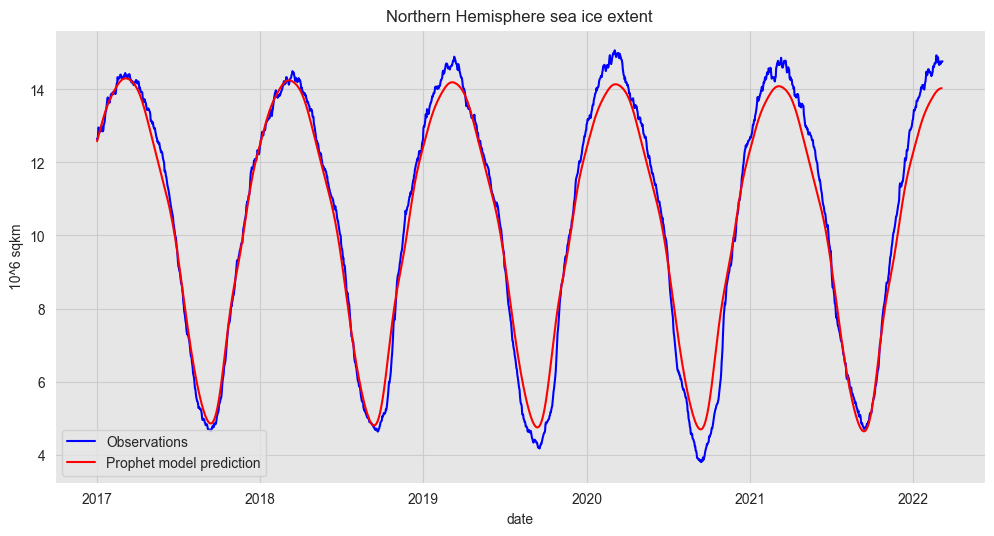

In [28]:
#comparing daily data with monthly data
import matplotlib.pyplot as plt
plt.plot(test_data.ds, test_data.y, 'b', predict_test.ds, predict_test.yhat, 'r')
plt.legend(['Observations', 'Prophet model prediction'])
plt.figsize=(8,8)

plt.gca().update(dict(title='Northern Hemisphere sea ice extent', xlabel='date', ylabel=r'10^6 sqkm'))
plt.savefig('north_prophet.png')

Using prophet for predicting ice extent in regions: Sea of Ohkotsk, Hudson Bay, Central Arctic